# GitHub Archive Analysis - Hype vs. Reality Index

The goal of this project is to analyze GitHub Archive data to compute the **Hype vs. Reality Index** for organizations.

This index compares:
- **Hype (Passive Interest)**: WatchEvents - users watching repositories
- **Reality (Active Development)**: PushEvents - actual code commits

## Documentation
- [Spark Programming Guide](https://spark.apache.org/docs/3.5.0/rdd-programming-guide.html)
- [PySpark RDD APIs](https://spark.apache.org/docs/3.5.0/api/python/reference/api/pyspark.RDD.html)

## Dataset Information and retrieval

- **Source**: [GH Archive](https://www.gharchive.org/)
- **Period**: 2024-01-01 to 2024-01-03 (3 days, 24 hours each = 72 files)
- **Format**: JSON.gz files
- **Sample file**: gh_data/2024-01-01-0.json.gz (for development)
- **Full dataset**: gh_data/2024-01-*.json.gz

You can download the dataset by executingthe scripts:
- [download_only_sample_dataset.sh](../../../download_only_sample_dataset.sh)
- [download_full_dataset.sh](../../../download_full_dataset.sh)

## Spark and dataset setup 

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[4]") \
    .appName("GitHub Archive Analysis") \
    .config('spark.ui.port', '4040') \
    .getOrCreate()
sc = spark.sparkContext

sc

<SparkContext master=local[4] appName=GitHub Archive Analysis>

In [2]:
# Paths configuration
path_to_datasets = "../../../gh_data/"

# Sample file for development (single hour ~10-50 MB)
path_sample = path_to_datasets + "2024-01-01-0.json.gz"

# Full dataset (all 72 files)
path_full = path_to_datasets + "2024-01-*.json.gz"

## Dataset parsing Class

In [3]:
import json
from typing import Optional, Tuple
from datetime import datetime

PASSIVE_EVENTS = {'Watch', 'Fork'}
ACTIVE_EVENTS = {
    'Push', 'PullRequest', 'PullRequestReview', 
    'PullRequestReviewComment', 'CommitComment', 
    'Create', 'Delete', 'Release', 'Gollum', 
    'Issues', 'IssueComment'
}

class GHArchiveParser:
    """Parser for GitHub Archive JSON events"""
    
    @staticmethod
    def parse_event(line: str) -> Optional[Tuple[str, str, str, str, str]]:
        """
        Parse a GitHub event JSON line.
        Returns: (event_id, event_type, org_login, repo_name, created_at)
        """
        try:
            event = json.loads(line)
            
            event_id = event.get('id', '')
            event_type = event.get('type', '').split('Event')[0]
            
            # Get organization (may be None for personal repos)
            org = event.get('org', {})
            org_login = org.get('login', 'NO_ORG') if org else 'NO_ORG'
            
            # Get repository name
            repo = event.get('repo', {})
            repo_name = repo.get('name', '') if repo else ''
            
            # Get timestamp
            created_at = event.get('created_at', '')
            
            return (event_id, event_type, org_login, repo_name, created_at)
        except Exception as e:
            return None
    
    @staticmethod
    def extract_date(timestamp: str) -> Optional[str]:
        """Extract date (YYYY-MM-DD) from ISO timestamp"""
        try:
            return timestamp.split('T')[0]
        except Exception:
            return None
    
    @staticmethod
    def is_passive(event_type: str) -> bool:
        """Check if event is an Event for passive interest"""
        return event_type in PASSIVE_EVENTS

    @staticmethod
    def is_active(event_type: str) -> bool:
        """Check if event is an Event for active development"""
        return event_type in ACTIVE_EVENTS

## Dataset Loading

In [4]:
rddEventsSample = sc.textFile(path_sample) \
    .map(GHArchiveParser.parse_event) \
    .filter(lambda x: x is not None)

In [5]:
rddEvents = sc.textFile(path_full) \
    .map(GHArchiveParser.parse_event) \
    .filter(lambda x: x is not None)

## Dataset Exploration

Cache the full dataset and answer the following questions:

- How many total events?
- Which are the distinct event types?
- How many distinct organizations?
- How many distinct repositories?
- How many passive interest Events?
- How many active development Events?
- How many discarded Events?
- How many Events with no organization?
- What is the passive/active ratio?
- What is the distribution of event types?
- On average, how many events per repository?

In [6]:
rddEventsCached = rddEvents.cache()

# Force materialization
total_events = rddEventsCached.count()
print(f"Dataset cached. Total events: {total_events:,}")

Dataset cached. Total events: 12,999,008


In [7]:
print("=== Basic Statistics ===")
print(f"Distinct event types: {rddEventsCached.map(lambda x: x[1]).distinct().collect():}")
print(f"Distinct organizations count: {rddEventsCached.map(lambda x: x[2]).distinct().count():,}")
print(f"Distinct repositories count: {rddEventsCached.map(lambda x: x[3]).distinct().count():,}")

=== Basic Statistics ===
Distinct event types: ['Issues', 'Push', 'PullRequest', 'IssueComment', 'CommitComment', 'Public', 'Release', 'Member', 'Watch', 'PullRequestReviewComment', 'Fork', 'Gollum', 'Delete', 'PullRequestReview', 'Create']
Distinct organizations count: 87,407
Distinct repositories count: 1,547,244


In [8]:
print("=== Event Statistics ===")
passive_count = rddEventsCached.filter(lambda x: GHArchiveParser.is_passive(x[1])).count()
active_count = rddEventsCached.filter(lambda x: GHArchiveParser.is_active(x[1])).count()
discarded_count = total_events - passive_count - active_count
no_org_count = rddEventsCached.filter(lambda x: x[2] == 'NO_ORG').count()

print(f"Events with passive interest: {passive_count:,}")
print(f"Events with active development: {active_count:,}")
print(f"Events discarded: {discarded_count:,}")
print(f"Events with no organization: {no_org_count:,}")
print(f"Passive/Active ratio: {passive_count/active_count:.2f}")

=== Event Statistics ===
Events with passive interest: 664,607
Events with active development: 12,273,419
Events discarded: 60,982
Events with no organization: 10,149,421
Passive/Active ratio: 0.05


In [9]:
print("=== Event Types Ranking ===")
event_distribution = rddEventsCached \
    .map(lambda x: (x[1], 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda x: x[1], ascending=False) \
    .collect()

for event_type, count in event_distribution:
    print(f"{event_type:25s}: {count:10,} ({count/total_events*100:5.2f}%)")

=== Event Types Ranking ===
Push                     :  8,562,308 (65.87%)
Create                   :  1,364,765 (10.50%)
PullRequest              :    800,392 ( 6.16%)
Watch                    :    542,622 ( 4.17%)
IssueComment             :    517,704 ( 3.98%)
Delete                   :    353,592 ( 2.72%)
PullRequestReview        :    223,470 ( 1.72%)
Issues                   :    202,559 ( 1.56%)
PullRequestReviewComment :    127,794 ( 0.98%)
Fork                     :    121,985 ( 0.94%)
Release                  :     66,695 ( 0.51%)
CommitComment            :     39,062 ( 0.30%)
Public                   :     36,722 ( 0.28%)
Member                   :     24,260 ( 0.19%)
Gollum                   :     15,078 ( 0.12%)


In [10]:
print("=== Averages ===")
avg_events_per_repo = rddEventsCached \
    .map(lambda x: (x[3], 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .map(lambda x: (x[1], 1)) \
    .reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]))

print(f"Average events per repository: {avg_events_per_repo[0]/avg_events_per_repo[1]:.2f}")

=== Averages ===
Average events per repository: 8.40


## Main Job: Hype vs. Reality Index

Compute the average **Hype vs. Reality Index** per project within the organization:

- **Hype Score**: Number of passive interest Events
- **Reality Score**: Number of active development Events
- **Hype vs. Reality Index**: `passive_count / (active_count + 1)` 
- Higher values = more hype relative to actual development
- Lower values = more development relative to hype
- This mathematically forces computing at Repo level first, due to the fact that average is not commutative

Export results to CSV with columns:
- `org_login`
- `avg_repo_hype_index`
- `repo_count`

In [11]:
path_output_hype_index = "output/hype_reality_index"

# Clear all cached RDDs before running jobs
for (id, rdd) in sc._jsc.getPersistentRDDs().items():         
    rdd.unpersist()

In [12]:
del rddEventsCached

In [13]:
from pyspark import StorageLevel 
rddPAEvents = rddEvents \
    .filter(lambda x: x[1] in PASSIVE_EVENTS or x[1] in ACTIVE_EVENTS) \
    .persist(StorageLevel.MEMORY_AND_DISK) # Use DISK spillover for safety

# Force Cache Materialization (Action)
count_events = rddPAEvents.count()
print(f"Cached {count_events} valid events.")

Cached 12938026 valid events.


### Non-Optimized

**Execution plan**: 
1. Aggregate passive Events by organization
2. Aggregate active Events by organization  
3. Full outer join to combine results

In [33]:
hype_index_avg_non_opt = rddPAEvents \
    .map(lambda x: ((x[2], x[3]), x[1])) \
    .groupByKey() \
    .map(lambda x: (
        x[0][0],   # Key: Org
                   # Value: RepoIndex
        sum(1 for e in x[1] if GHArchiveParser.is_passive(e)) / (sum(1 for e in x[1] if GHArchiveParser.is_active(e)) + 1)
    )) \
    .groupByKey() \
    .mapValues(lambda x: sum(x)/len(x)) \
    .map(lambda x: (x[1], x[0])) \
    .sortByKey(False) \
    .map(lambda x: (x[1], x[0]))

# Export
hype_index_avg_non_opt.coalesce(1) \
    .toDF(["org_login", "avg_repo_hype_index"]) \
    .write.format("csv") \
    .mode('overwrite') \
    .option("header", "true") \
    .save(path_output_hype_index + "_avg_non_opt")

print("Job Complete. Check Spark UI for partition sizes!")

Job Complete. Check Spark UI for partition sizes!


In [34]:
hype_index_max_non_opt = rddPAEvents \
    .map(lambda x: ((x[2], x[3]), x[1])) \
    .groupByKey() \
    .map(lambda x: (
        x[0][0],   # Key: Org
                   # Value: RepoIndex
        sum(1 for e in x[1] if GHArchiveParser.is_passive(e)) / (sum(1 for e in x[1] if GHArchiveParser.is_active(e)) + 1)
    )) \
    .groupByKey() \
    .mapValues(lambda x: max(x)) \
    .map(lambda x: (x[1], x[0])) \
    .sortByKey(False) \
    .map(lambda x: (x[1], x[0]))

# Export
hype_index_max_non_opt.coalesce(1) \
    .toDF(["org_login", "max_repo_hype_index"]) \
    .write.format("csv") \
    .mode('overwrite') \
    .option("header", "true") \
    .save(path_output_hype_index + "_max_non_opt")

print("Job Complete. Check Spark UI for partition sizes!")

Job Complete. Check Spark UI for partition sizes!


### Optimization
Common stages
1. Transform: Declare if the event is Passive or Active
    - Map to `((Org, Repo), (isPassive, isActive))` 
2. FIRST AGGREGATION: Totals per Repository
    - Reduce to `((Org, Repo), (passive_count, active_count))` 
3. Transform: Calculate Index per Repo and keep only the Organisation
    - Map to `(Org, RepoIndex)`

So we can cache the result till here

In [16]:
# Configuration for partitioning
DEFAULT_PARALLELISM = sc.defaultParallelism
HIGH_PARTITIONS = DEFAULT_PARALLELISM * 4  # 16 partitions for Repo Aggregation
LOW_PARTITIONS = DEFAULT_PARALLELISM       # 4 partitions for Org Aggregation

In [17]:
hype_index_per_org_repo = rddPAEvents \
    .map(lambda x: (
        (x[2], x[3]), # Key: (Org, Repo)
        (1, 0) if GHArchiveParser.is_passive(x[1]) else (0, 1) # Value: (Passive, Active)
    )) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]), numPartitions=HIGH_PARTITIONS) \
    .map(lambda x: (
        x[0][0],                # Key: Org
        x[1][0] / (x[1][1] + 1) # Value: RepoIndex
    )) \
    .persist()
hype_index_per_org_repo.count()

1523438

Now that I have computed the Hype Index for each repo, I can do separate calculations: first the average

4. Transform: Add a value to count the repos
    - Map to `(Org, (RepoIndex, 1))`
5. SECOND AGGREGATION: Totals per Organisation
    - Reduce to `(Org, (RepoIndex_sum, repo_count))`
6. Transform: Calculate the average
   - Map to `(Org, AvgOrgIndex)`
7. Transform: Swap Key-Value
   - Map to `(AvgOrgIndex, Org)`
8. Sort By Key `AvgOrgIndex`

In [30]:
hype_index_avg_opt = hype_index_per_org_repo \
    .mapValues(lambda x: 
        (x, 1) # Value: (Repo_Hype_Index, 1) -> 1 is for counting repos
    ) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]), numPartitions=LOW_PARTITIONS) \
    .mapValues(lambda x: x[0] / x[1]) \
    .map(lambda x: (x[1], x[0])) \
    .sortByKey(False) \
    .map(lambda x: (x[1], x[0]))

# Export
hype_index_avg_opt.coalesce(1) \
    .toDF(["org_login", "avg_repo_hype_index"]) \
    .write.format("csv") \
    .mode('overwrite') \
    .option("header", "true") \
    .save(path_output_hype_index + "_avg_opt")

print("Job Complete. Check Spark UI for partition sizes!")

Job Complete. Check Spark UI for partition sizes!


Then the max with a single aggregation

5. SECOND AGGREGATION: Totals per Organisation
    - Reduce to `(Org, MaxRepoIndex)`
6. Transform: Swap Key-Value
   - Map to `(MaxOrgIndex, Org)`
7. Sort By Key `MaxOrgIndex`

In [31]:
hype_index_max_opt = hype_index_per_org_repo \
    .reduceByKey(lambda a, b: max(a, b), numPartitions=LOW_PARTITIONS) \
    .map(lambda x: (x[1], x[0])) \
    .sortByKey(False) \
    .map(lambda x: (x[1], x[0]))

# Export
hype_index_max_opt.coalesce(1) \
    .toDF(["org_login", "max_repo_hype_index"]) \
    .write.format("csv") \
    .mode('overwrite') \
    .option("header", "true") \
    .save(path_output_hype_index + "_max_opt")

print("Job Complete. Check Spark UI for partition sizes!")

Job Complete. Check Spark UI for partition sizes!


## Results Verification

### Verify

In [36]:
def are_rdds_equal(rdd1, rdd2):
    # Check 1: Quick fail if counts are different
    c1 = rdd1.count()
    c2 = rdd2.count()
    
    if c1 != c2:
        print(f"Count mismatch: {c1} vs {c2}")
        return False
    
    # Check 2: Subtract check (Distributed)
    # rdd1.subtract(rdd2) returns elements in rdd1 that are NOT in rdd2
    # If the result is empty, it means rdd2 contains everything rdd1 has.
    diff1 = rdd1.subtract(rdd2)
    diff2 = rdd2.subtract(rdd1)
    
    if diff1.isEmpty() and diff2.isEmpty():
        return True
    else:
        print(diff1.collect())
        # print(diff2.collect())
        return False


In [37]:
# Join the two RDDs by key (Project Name) to compare values side-by-side
# Structure: (Project, (Score_NonOpt, Score_Opt))
def are_rdds_equal_with_tolerance(rdd1, rdd2, tol):
    comparison_rdd = rdd1 \
        .join(rdd2.map(lambda x: (x[1], x[0])))
    
    # Filter to find ONLY the significant differences
    real_diffs = comparison_rdd.filter(lambda x: abs(x[1][0] - x[1][1]) > tol)
    count_diffs = real_diffs.count()
    if count_diffs == 0:
        print(f"Success! The RDDs match (ignoring tiny float errors < {tol})")
    else:
        print(f"Found {count_diffs} real differences!")
        print(real_diffs.take(5))

In [38]:
are_rdds_equal_with_tolerance(hype_index_avg_opt, hype_index_avg_non_opt, 1e-6)

Success! The RDDs match (ignoring tiny float errors < 1e-06)


In [39]:
are_rdds_equal(hype_index_max_opt, hype_index_max_non_opt)

True

### Plot results

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_results(data, metric, title): 
    df = pd.DataFrame(data, columns=['Organisation', metric])
    
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 1, figsize=(12, 4))
    sns.barplot(
        ax=axes,
        data=df,
        x='Organisation',
        y=metric,
        hue=metric,
        palette='viridis',
        dodge=False
    )
    axes.set_title(title)
    plt.tight_layout()
    plt.show()

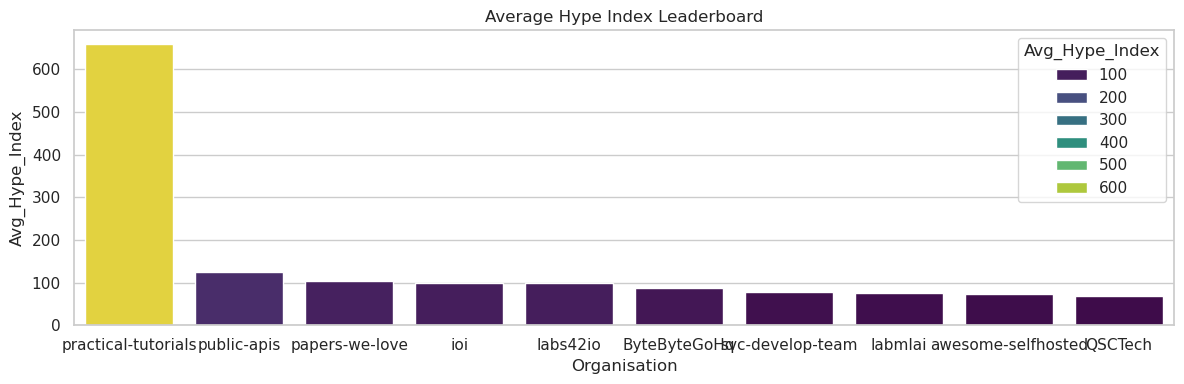

In [40]:
plot_results(hype_index_avg_opt.take(10), 'Avg_Hype_Index', 'Average Hype Index Leaderboard')

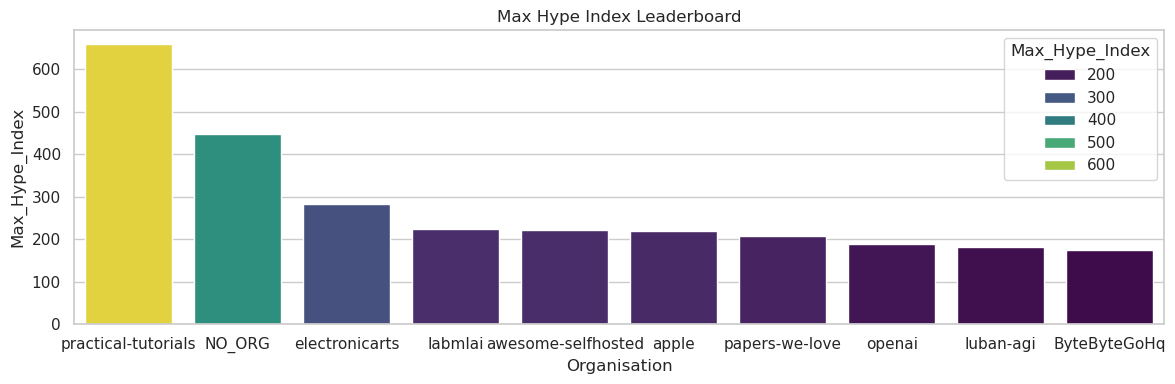

In [41]:
plot_results(hype_index_max_opt.take(10), 'Max_Hype_Index', 'Max Hype Index Leaderboard')

## Performance Analysis

Compare execution plans in Spark UI:

Go to [localhost:4040](http://localhost:4040) to see detailed execution plans.